<a href="https://colab.research.google.com/github/Nishankur/Image-Processing-Practice/blob/main/ImageRec_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import PIL
import PIL.Image as pim

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
#folders in the directory
folders = list(tf.io.gfile.listdir(data_dir))
folders

['roses', 'tulips', 'LICENSE.txt', 'sunflowers', 'dandelion', 'daisy']

In [ ]:
#total number of images
image_count = list(data_dir.glob('*/*.jpg'))
len(image_count)

3670

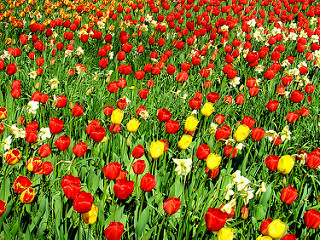

In [ ]:
img = list(data_dir.glob('tulips/*'))
pim.open(str(img[0]))


In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


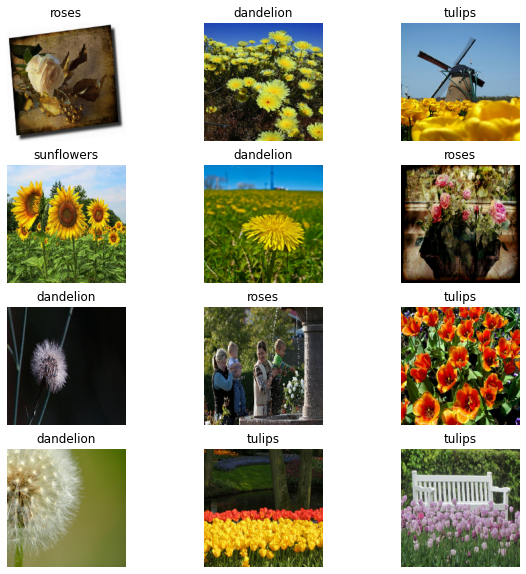

In [ ]:
plt.figure(figsize=[10,10])
for image,label in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[label[i]])
    plt.axis('off')

  
  

In [ ]:
def norm(image):
  return tf.cast(image,tf.float32)/255.

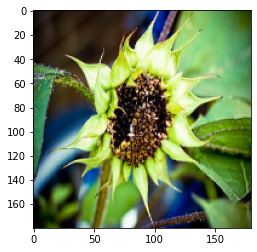

In [ ]:
#Checking the image after rescaling
test_im_batch,label_batch = next(iter(train_ds.take(1)))
norm_im = norm(test_im_batch[1])
plt.imshow(norm_im)

In [ ]:
#Checking the result of rescaling
norm_im

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[4.52941172e-02, 2.17647068e-02, 3.74509804e-02],
        [5.28140925e-02, 2.53631081e-02, 5.28140925e-02],
        [6.31239414e-02, 3.56729627e-02, 6.31239414e-02],
        ...,
        [1.26317948e-01, 2.05346018e-01, 0.00000000e+00],
        [1.12374648e-01, 1.88064516e-01, 3.26801371e-03],
        [1.00827873e-01, 1.75337687e-01, 2.45701085e-04]],

       [[4.85838801e-02, 2.50544660e-02, 4.07407433e-02],
        [5.74509837e-02, 3.00000031e-02, 5.74509837e-02],
        [6.81263655e-02, 4.06753831e-02, 6.81263655e-02],
        ...,
        [1.38583750e-01, 2.20824093e-01, 1.79009128e-03],
        [1.24640442e-01, 2.03387707e-01, 1.68847374e-03],
        [1.13093674e-01, 1.89498901e-01, 1.94625964e-03]],

       [[5.17429188e-02, 2.82135084e-02, 4.38997820e-02],
        [6.00036308e-02, 3.25526521e-02, 6.00036308e-02],
        [7.03280047e-02, 4.28770296e-02, 7.03280047e-02],
        ...,
        [1.47996768e-01, 2.33333

Model training after rescaling

In [ ]:
#Caching the dataset and enabling prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
num_classes = 5

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 148s 2s/step - loss: 1.2749 - accuracy: 0.4683 - val_loss: 1.0314 - val_accuracy: 0.5858
Epoch 2/10
92/92 [==============================] - 129s 1s/step - loss: 0.9593 - accuracy: 0.6267 - val_loss: 0.9804 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 129s 1s/step - loss: 0.7854 - accuracy: 0.6989 - val_loss: 1.0310 - val_accuracy: 0.5967
Epoch 4/10
92/92 [==============================] - 131s 1s/step - loss: 0.5874 - accuracy: 0.7851 - val_loss: 1.0529 - val_accuracy: 0.6144
Epoch 5/10
92/92 [==============================] - 133s 1s/step - loss: 0.4047 - accuracy: 0.8569 - val_loss: 1.1071 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 130s 1s/step - loss: 0.3035 - accuracy: 0.8944 - val_loss: 1.2256 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 132s 1s/step - loss: 0.2658 - accuracy: 0.9101 - val_loss: 1.3855 - val_accuracy: 0.6526
Epoch 8/10
92

In [ ]:
#With data augmentation and dropout
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f98ce6925d0>>

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 110s 1s/step - loss: 1.3684 - accuracy: 0.4012 - val_loss: 1.1096 - val_accuracy: 0.5041
Epoch 2/10
92/92 [==============================] - 108s 1s/step - loss: 1.0724 - accuracy: 0.5671 - val_loss: 1.0517 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 110s 1s/step - loss: 0.9880 - accuracy: 0.6069 - val_loss: 1.0166 - val_accuracy: 0.5899
Epoch 4/10
92/92 [==============================] - 108s 1s/step - loss: 0.9309 - accuracy: 0.6345 - val_loss: 1.0043 - val_accuracy: 0.6035
Epoch 5/10
92/92 [==============================] - 109s 1s/step - loss: 0.9105 - accuracy: 0.6417 - val_loss: 0.8967 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 108s 1s/step - loss: 0.8528 - accuracy: 0.6594 - val_loss: 0.8236 - val_accuracy: 0.6744
Epoch 7/10
92/92 [==============================] - 109s 1s/step - loss: 0.8023 - accuracy: 0.6836 - val_loss: 0.8606 - val_accuracy: 0.6621
Epoch 8/10
92

After applying data augmentation and dropout the model seems to perform much better than the model with only rescaling, after 10 epochs, with an accuracy of 70% on the validation set.

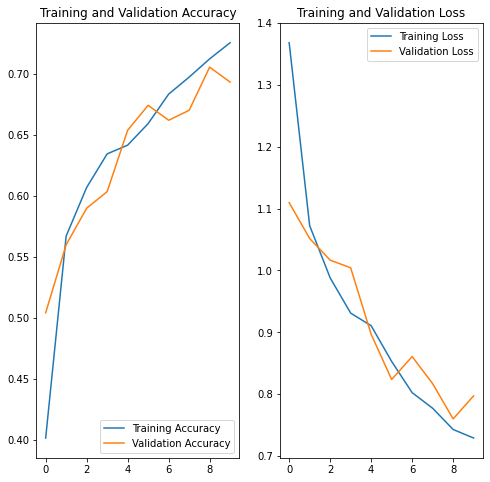

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()